# Full PyTorch Workflow

Doing a full workflow in a more straightforward way.

1. Data (prepare and load)
2. Build model
3. Fit model to data (training)
4. Making predictions and evaluating a model (inference)
5. Saving and loading a model


## Setup


In [1]:
# Importing data

# Type hinting
from typing import Tuple

# Utils
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Torch utils
import torch
from torch import nn

In [2]:
# Using gpu if available
device = 'mps' if torch.mps.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: mps


### Functions


In [3]:
# Function for visualizing data
def plot_model_data(
    train_data: torch.Tensor,
    train_labels: torch.Tensor,
    test_data: torch.Tensor,
    test_labels: torch.Tensor,
    predictions: torch.Tensor = None,
    figsize: Tuple = (10, 7),
) -> None:
    '''
    Plots training data, test data and compares predictions (if not none).
    '''

    plt.figure(figsize=figsize)

    # Training data
    plt.scatter(train_data, train_labels, c='r', s=4, label='training_data')

    # Testing data
    plt.scatter(test_data, test_labels, c='b', s=4, label='testing_data')

    # Predictions (if any)
    if predictions != None:
        plt.scatter(test_data, predictions, c='g', s=4, label='predictions')

    # Showing functions
    plt.legend()
    plt.show

## Creating data

Creating data with the linear regression formula ($\hat{Y} = bX + a$).


In [4]:
# Creating data
weight = 0.8
bias = 0.5

# Creating range of values
start = -5
end = 7
step = 0.03

# Create X and y
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

In [5]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(320, 320, 80, 80)

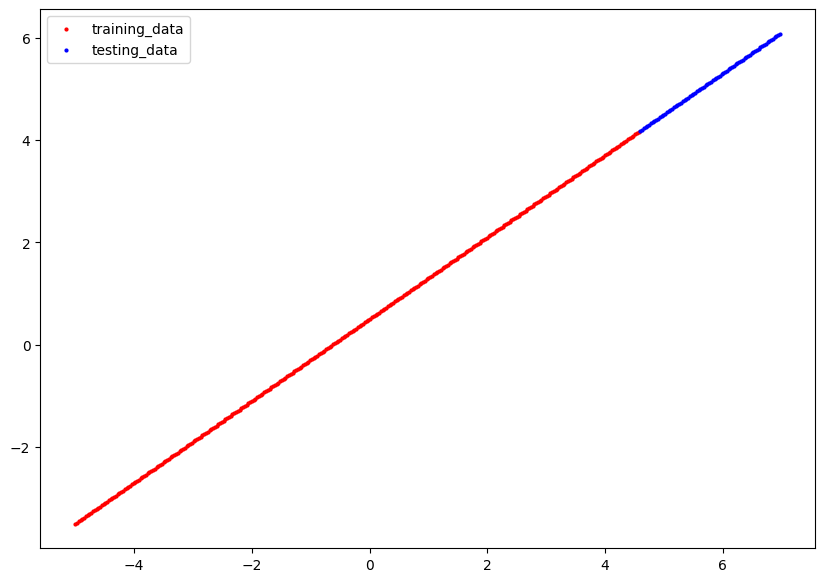

In [6]:
# Plotting data
plot_model_data(X_train, y_train, X_test, y_test)

## Building model


In [7]:
class LinearRegressionModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        # Using nn.Linear() for creating the model's parameters
        self.linear_layer = nn.Linear(in_features=1, out_features=1, device=device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

In [8]:
# Setting manual seed
torch.manual_seed(42)

# Instantiating model
lr_model = LinearRegressionModel()

# Instantiating loss function
loss_fn = nn.L1Loss()

# Instantiating optimizer
optimizer = torch.optim.SGD(params=lr_model.parameters(), lr=0.001)

In [9]:
# Initial state dict
lr_model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6344]], device='mps:0')),
             ('linear_layer.bias', tensor([-0.8678], device='mps:0'))])

## Training model


In [10]:
# Setting number of iterations
epochs = 1500

# Ensuring data is on the target device
X_train_gpu = X_train.to(device)
X_test_gpu = X_test.to(device)
y_train_gpu = y_train.to(device)
y_test_gpu = y_test.to(device)

# Data tracking dict
data_tracking = {
    'train_loss': [],
    'test_loss': [],
}

# Training model
for epoch in range(epochs):
    lr_model.train()
    train_preds = lr_model(X_train_gpu)

    training_loss = loss_fn(train_preds, y_train_gpu)
    data_tracking['train_loss'].append(training_loss)

    optimizer.zero_grad()
    training_loss.backward()

    optimizer.step()

    with torch.inference_mode():
        lr_model.eval()
        test_preds = lr_model(X_test_gpu)

        testing_loss = loss_fn(test_preds, y_test_gpu)
        data_tracking['test_loss'].append(testing_loss)

    if (epoch + 1) % 100 == 0:
        print(
            f'| Epoch: {epoch + 1} | Training loss: {training_loss:.4f} | Testing loss: {testing_loss:.4f} |'
        )
        print('-' * 60)

| Epoch: 100 | Training loss: 1.2287 | Testing loss: 2.3504 |
------------------------------------------------------------
| Epoch: 200 | Training loss: 1.1240 | Testing loss: 2.3748 |
------------------------------------------------------------
| Epoch: 300 | Training loss: 1.0232 | Testing loss: 2.3660 |
------------------------------------------------------------
| Epoch: 400 | Training loss: 0.9350 | Testing loss: 2.1971 |
------------------------------------------------------------
| Epoch: 500 | Training loss: 0.8475 | Testing loss: 1.9949 |
------------------------------------------------------------
| Epoch: 600 | Training loss: 0.7601 | Testing loss: 1.7887 |
------------------------------------------------------------
| Epoch: 700 | Training loss: 0.6726 | Testing loss: 1.5827 |
------------------------------------------------------------
| Epoch: 800 | Training loss: 0.5851 | Testing loss: 1.3765 |
------------------------------------------------------------
| Epoch: 900 | T

In [11]:
# Seeing state dict
lr_model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.8013]], device='mps:0')),
             ('linear_layer.bias', tensor([0.5000], device='mps:0'))])

## Testing Model


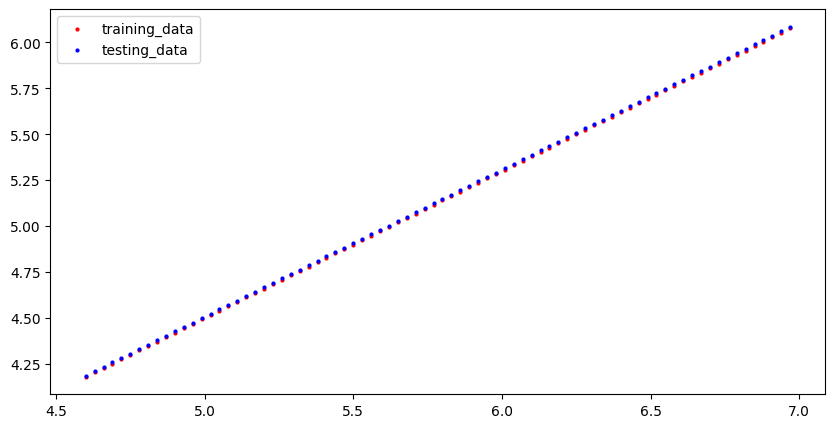

In [12]:
# Plotting predictions
with torch.inference_mode():
    y_preds = lr_model(X_test_gpu).cpu()
    plot_model_data(X_test, y_test, X_test, y_preds, figsize=(10, 5))

In [13]:
# Turning tensors into arrays
train_losses = torch.tensor(data_tracking['train_loss']).cpu().numpy()
test_losses = torch.tensor(data_tracking['test_loss']).cpu().numpy()

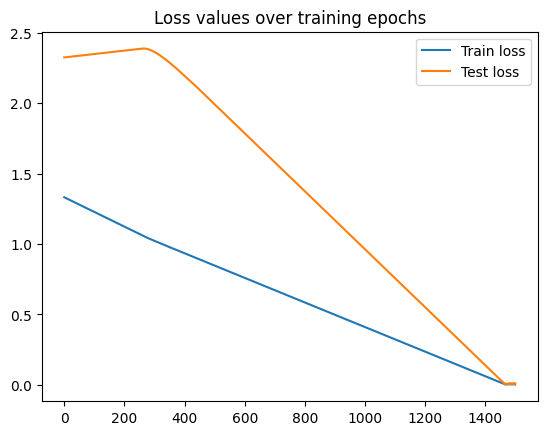

In [14]:
# Setting epoch range
epoch_range = [i for i in range(epochs)]

# Plotting loss functions
plt.plot(epoch_range, train_losses, label='Train loss')
plt.plot(epoch_range, test_losses, label='Test loss')
plt.title('Loss values over training epochs')
plt.legend()
plt.show()

## Saving and loading model


In [15]:
# Creating models directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Creating model save path
MODEL_NAME = 'lr_model.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

PosixPath('models/lr_model.pth')

In [16]:
# Saving model state_dict
torch.save(obj=lr_model.state_dict(), f=MODEL_SAVE_PATH)

In [17]:
# Loading model
model = LinearRegressionModel()
model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [18]:
# Predicting and checking validity
model.eval()
with torch.inference_mode():
    loaded_lr_preds = model(X_test_gpu).cpu()

torch.equal(loaded_lr_preds, y_preds)

True